In [312]:
import yaml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import panel as pn 
import copy

import csv
from scipy import stats
from statsmodels.distributions.empirical_distribution import ECDF
from bokeh.io import output_notebook, export_png
from bokeh.plotting import figure,show 
from bokeh.layouts import column, row, grid
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
output_notebook()
pn.extension()

Loading BokehJS ...

In [313]:
def get_config():
    with open("config.yaml", 'r') as stream:
        config = yaml.safe_load(stream)
    return config

In [314]:
def combine_datasets(ccre, euclidean):
    config = get_config()

    ccre_df = pd.read_csv(config[ccre])
    euclidean_df = pd.read_csv(config[euclidean])
    
    #combine
    df = pd.concat([euclidean_df, ccre_df], axis=1)
    df = df.loc[:,~df.columns.duplicated()].copy()
    hospitals = df['hospital'].str.split('_') 

    same_centre_bools = [] 
    for hospital in hospitals:
        if hospital[0] == hospital[1]:
            same_centre_bools.append(True)
        else:
            same_centre_bools.append(False)
    df['same_centre'] = same_centre_bools
    return df

In [315]:
df = combine_datasets(ccre="ccre_all", euclidean="euclidean_all")
df.loc[df['ccre(X|Y)'].str[0] == '[', "ccre(X|Y)"] = 0
df = df.astype({'ccre(X|Y)':'float'})
df = df.astype({'euclidean_similarity':'float'})
patients_to_remove = [23, 25, 27,30,32,34,35,36,40,52, 56, 104,110,111,117,120,134,140,148,159,161,162, 171,179,180,181,182,191,192,196,205,211,215,216, 230,233,236,237,238,239,242,243,245, 247,252,253,254,256,258,262,272,275,277,279,284,285,286,287,289,290,291,292,294,295,296,297,298,299,300,301,303]
df = df[(~df['id_x'].isin(patients_to_remove)) & ~df['id_y'].isin(patients_to_remove)]

In [316]:
df.fillna({'ccre(X|Y)': 1}, inplace=True)
df

,id_x,id_y,hospital,diagnosis,euclidean_distance,euclidean_similarity,cre(x),cre(y),E[cre(X|Y)],ccre(X|Y),same_centre
0,0,1,UMCG_UMCG,HC_HC,16.561167,0.056944,1.423117,1.280979,-1.354576,0.048162,True
1,19,0,UMCG_UMCG,PD_HC,17.831924,0.053101,2.186887,1.423117,-1.688956,0.227689,True
2,57,0,UMCG_UMCG,AD_HC,47.326398,0.020693,5.113884,1.423117,-4.217813,0.175223,True
3,38,0,UMCG_UMCG,PD_HC,39.546871,0.024663,3.877309,1.423117,-3.845329,0.008248,True
4,0,2,UMCG_UMCG,HC_HC,16.325006,0.057720,1.423117,1.274866,-1.283575,0.098054,True
...,...,...,...,...,...,...,...,...,...,...,...
91787,302,281,CUN_CUN,PD_PD,31.315242,0.030945,4.163102,2.812678,-2.939135,0.294004,True
91788,302,282,CUN_CUN,PD_PD,32.643134,0.029724,4.163102,2.832751,-3.036574,0.270598,True
91789,302,283,CUN_CUN,PD_PD,33.226441,0.029217,4.163102,1.770693,-2.940674,0.293634,True
91794,302,288,CUN_CUN,PD_PD,36.532513,0.026644,4.163102,2.939166,-3.446644,0.172097,True


In [317]:
def compare_scatter_plots(disease1="HC", disease2="HC"):
    
    combine_diseases = f"{disease1}_{disease2}"
    figures = []
    for i in sources_names:

        for j in sources_names:

            combine_centres = f"{i}_{j}"
            dataset = df[(df.hospital == combine_centres) & (df.diagnosis == combine_diseases)]
         

            figure1 = figure(height=400, width=400, title=f"{combine_centres} {combine_diseases}")
            figure1.scatter('ccre(X|Y)', 'euclidean_similarity', source=dataset)
            figure1.xaxis.axis_label = "ccre"
            figure1.yaxis.axis_label = "euclidean similarity"
            figures.append(figure1)
    
    return grid([
        [figures[0], figures[1], figures[2]],
        [figures[3], figures[4], figures[5]],
        [figures[6], figures[7], figures[8]]
    ])
            

sources_names = ["UMCG", "UGOSM", "CUN"]
diagnosis = ["HC", "AD", "PD"]
scatter_plots = pn.interact(compare_scatter_plots, disease1=diagnosis, disease2=diagnosis)
scatter_plots

BokehModel(combine_events=True, render_bundle={'docs_json': {'c9f3e289-194f-4220-8459-69560e083e8d': {'version…

In [318]:
def cumulative_histogram(diagnosis1 = "PD", diagnosis2 = "PD"):
    
    combine_diseases = f"{diagnosis1}_{diagnosis2}"
    figures = []
    for i in sources_names:

        for j in sources_names:

            combine_centres = f"{i}_{j}"
            data = df[(df.hospital == combine_centres) & (df.diagnosis == combine_diseases)]
            
            ecdf = ECDF(data['ccre(X|Y)'])
            ecdf2 = ECDF(data['euclidean_similarity'])
           
            plot1 = figure(width=400, height=400, title=f"{combine_centres} {combine_diseases}")
            plot1.line(ecdf.x, ecdf.y)
            plot1.line(ecdf2.x, ecdf2.y, color='orange')
          
            figures.append(plot1)
    

    return grid([
        [figures[0], figures[1], figures[2]],
        [figures[3], figures[4], figures[5]],
        [figures[6], figures[7], figures[8]]
    ])
cumulative_plots = pn.interact(cumulative_histogram, diagnosis1=diagnosis, diagnosis2=diagnosis)
cumulative_plots


BokehModel(combine_events=True, render_bundle={'docs_json': {'acc48dc6-83eb-43bd-8f6b-654056d37116': {'version…

In [319]:
sorted_df = df.sort_values(['hospital', 'diagnosis'])


In [320]:
list_of_id = sorted_df['id_x'].unique()

def adjacency_matrix(metric):
    squared_matrix = []
    temp_values = []
    for i in list_of_id:
 
        

        for j in list_of_id:
            if i == j:
                temp_values.append(1)
            else:

                temp_values.append(sorted_df[(sorted_df['id_x'] == i) & (sorted_df['id_y'] == j)][metric].values[0])
        if len(temp_values) == len(list_of_id):
            
            squared_matrix.append(temp_values)
            temp_values = []
    return squared_matrix
CCRE_matrix = adjacency_matrix('ccre(X|Y)')
euclidean_matrix = adjacency_matrix('euclidean_similarity')


In [321]:
df

,id_x,id_y,hospital,diagnosis,euclidean_distance,euclidean_similarity,cre(x),cre(y),E[cre(X|Y)],ccre(X|Y),same_centre
0,0,1,UMCG_UMCG,HC_HC,16.561167,0.056944,1.423117,1.280979,-1.354576,0.048162,True
1,19,0,UMCG_UMCG,PD_HC,17.831924,0.053101,2.186887,1.423117,-1.688956,0.227689,True
2,57,0,UMCG_UMCG,AD_HC,47.326398,0.020693,5.113884,1.423117,-4.217813,0.175223,True
3,38,0,UMCG_UMCG,PD_HC,39.546871,0.024663,3.877309,1.423117,-3.845329,0.008248,True
4,0,2,UMCG_UMCG,HC_HC,16.325006,0.057720,1.423117,1.274866,-1.283575,0.098054,True
...,...,...,...,...,...,...,...,...,...,...,...
91787,302,281,CUN_CUN,PD_PD,31.315242,0.030945,4.163102,2.812678,-2.939135,0.294004,True
91788,302,282,CUN_CUN,PD_PD,32.643134,0.029724,4.163102,2.832751,-3.036574,0.270598,True
91789,302,283,CUN_CUN,PD_PD,33.226441,0.029217,4.163102,1.770693,-2.940674,0.293634,True
91794,302,288,CUN_CUN,PD_PD,36.532513,0.026644,4.163102,2.939166,-3.446644,0.172097,True


In [322]:
df[df['id_x'] == list_of_id[232]]['diagnosis'].values[0].split('_')[0]

'PD'

In [323]:

hospital_diagnosis_full = []

for i in list_of_id:
    
    hospital = df[df['id_x'] == i]['hospital'].values[0].split('_')[0]
    diagnosis = df[df['id_x'] == i]['diagnosis'].values[0].split('_')[0]
    hospital_diagnosis_full.append(f'{hospital}_{diagnosis}')


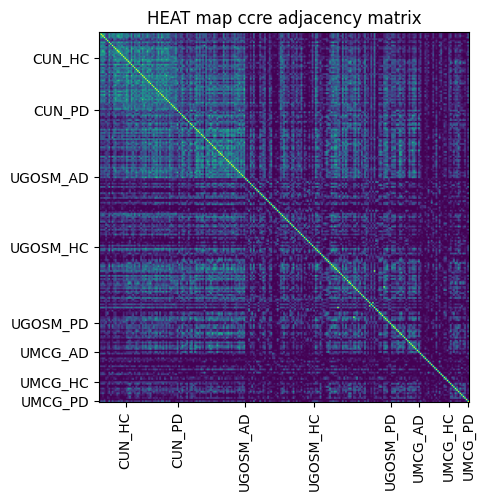

In [324]:
position = [16, 49, 91, 135, 183, 201, 220, 232]
hospital_diagnosis = ['CUN_HC', 'CUN_PD', 'UGOSM_AD', 'UGOSM_HC', 'UGOSM_PD', 'UMCG_AD', 'UMCG_HC', 'UMCG_PD']
plt.xticks(position, hospital_diagnosis, rotation='vertical')
plt.yticks(position, hospital_diagnosis)
plt.title('HEAT map ccre adjacency matrix')
plt.imshow(CCRE_matrix, vmin=0, vmax=1)


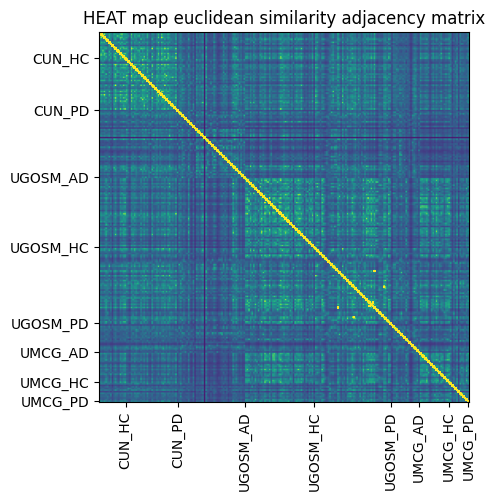

In [325]:

plt.xticks(position, hospital_diagnosis, rotation='vertical')
plt.yticks(position, hospital_diagnosis)
plt.title('HEAT map euclidean similarity adjacency matrix')
plt.imshow(euclidean_matrix, vmin=0, vmax=0.1)

In [326]:
ill_notill = []
one_or_zero = []
for i in hospital_diagnosis_full:
    if i[-2:] == 'AD' or i[-2:] ==  'PD':
        ill_notill.append('ill')
        one_or_zero.append(1)
    else:
        ill_notill.append('notill')
        one_or_zero.append(0)

<h1>LDA</h1>

In [327]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis 
from sklearn import datasets
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis 
iris = datasets.load_iris()


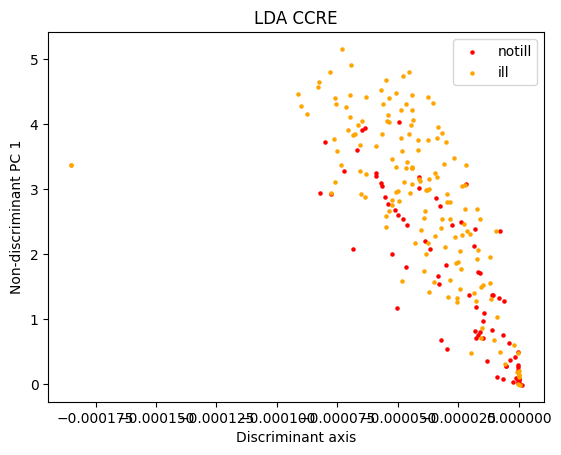

In [328]:
def lda(X, y, title):
     #devide the data
    ill = []
    notill = []
    for index, label in enumerate(y):
        if label == 0:
            notill.append(X[index])
        else:
            ill.append(X[index])
    ill = np.array(ill)
    notill = np.array(notill)
   
    # calculate mean and covariance
    Mill = ill.mean(axis=0)
    Mnotill = notill.mean(axis=0)
    nill = ill.shape[0]
    nnotill = notill.shape[0]
    Cill = np.cov(ill.T)
    Cnotill = np.cov(notill.T)

    #calculate the pooled covariance matrix
    Sp = ((nnotill - 1) * Cnotill + (nill - 1) * Cill) / (nnotill + nill - 2)

    #project data onto the discriminant axis
    a = np.linalg.inv(Sp) @ (Mill - Mnotill) 
    a /= np.sqrt((a ** 2).sum())

    tw = ill @ a 
    tr = notill @ a

    #plot 
    Ew = ill - tw[:, None] * a[None, :]
    Er = notill - tr[:, None] * a[None, :]

    X = np.concatenate((Ew, Er), axis=0)
    S = np.cov(X.T)
    vals, vecs = np.linalg.eig(S)
    order = vals.argsort()[::-1]
    vecs = vecs[:, order]
    vals = vals[order]
    Tw = ill @ vecs
    Tr = notill @ vecs
    plt.title(f"LDA {title}")
    plt.scatter(tr, Tr[:, 0], s=5, c="red", label='notill')
    plt.scatter(tw, Tw[:, 0], s=5, c="orange", label='ill')
    plt.xlabel("Discriminant axis")
    plt.ylabel("Non-discriminant PC 1")
    plt.legend()

lda(CCRE_matrix, one_or_zero, "CCRE")

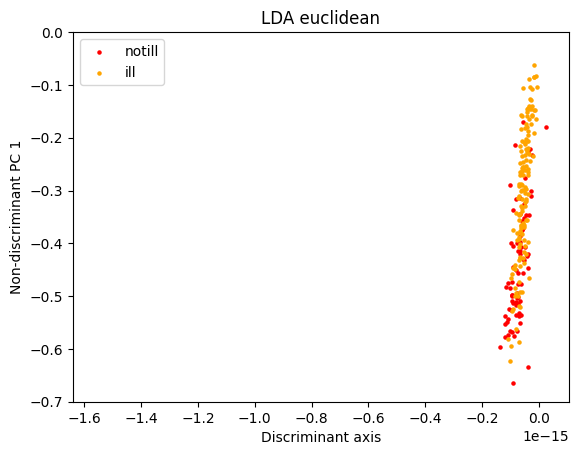

In [329]:

plt.ylim(-0.7,0)
lda(euclidean_matrix, one_or_zero, "euclidean")

PCA

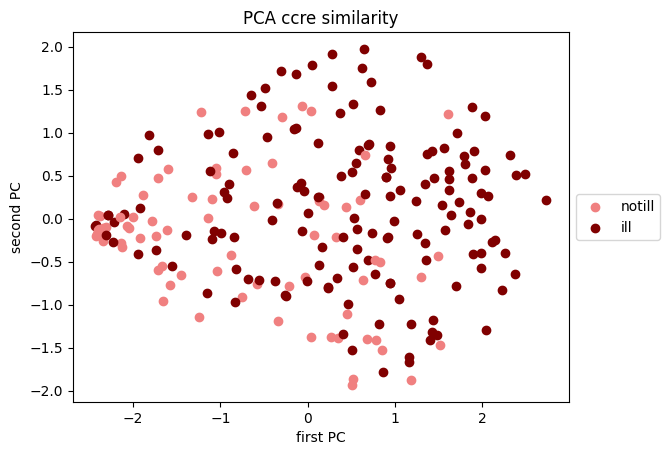

In [330]:
from collections import OrderedDict
X = np.array(CCRE_matrix)
pca = PCA(n_components=232)
pca_fit = pca.fit_transform(X)
data = {'pc1': pca_fit[:, 0], 'pc2':pca_fit[:, 1], 'labels': ill_notill}
test = pd.DataFrame(data).values
colors = {'ill': 'maroon', 'notill': 'lightcoral'}
for i in test:
    plt.scatter(i[0], i[1], color=colors[i[2]],label=i[2])
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.title('PCA ccre similarity')
plt.xlabel('first PC')
plt.ylabel('second PC')
plt.legend(by_label.values(), by_label.keys(), loc='center left', bbox_to_anchor=(1, 0.5))

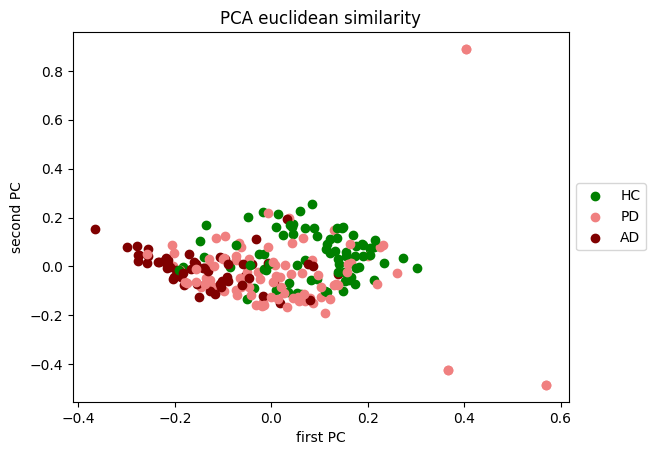

In [331]:
X = np.array(euclidean_matrix)
pca = PCA(n_components=232)
pca_fit = pca.fit_transform(X)
data = {'pc1': pca_fit[:, 0], 'pc2':pca_fit[:, 1], 'labels': ad_pd_hc}
test = pd.DataFrame(data).values
colors = {'AD': 'maroon', 'PD': 'lightcoral', 'HC': 'green'}
for i in test:
    plt.scatter(i[0], i[1], color=colors[i[2]],label=i[2])
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.title('PCA euclidean similarity')
plt.xlabel('first PC')
plt.ylabel('second PC')

plt.legend(by_label.values(), by_label.keys(), loc='center left', bbox_to_anchor=(1, 0.5))

In [332]:
def compare_metrics(hospital, first_diagnosis, second_diagnosis):

    first = df[(df['hospital'] == hospital) & (df['diagnosis'] == f"{first_diagnosis}_{first_diagnosis}")]
    second = df[(df['hospital'] == hospital) & (df['diagnosis'] == f"{second_diagnosis}_{second_diagnosis}")]

    third = df[(df['hospital'] == hospital) & (df['diagnosis'] == f"{first_diagnosis}_{second_diagnosis}")]
    fourth = df[(df['hospital'] == hospital) & (df['diagnosis'] == f"{second_diagnosis}_{first_diagnosis}")]
    
    #euclidean distance
    euclidean_first = first['euclidean_distance'].median() / (pd.concat([third['euclidean_distance'], fourth['euclidean_distance']])).median()
    euclidean_second = second['euclidean_distance'].median() / (pd.concat([third['euclidean_distance'], fourth['euclidean_distance']])).median()
    
    #ccre
    ccre_first = (1- first['ccre(X|Y)']).median() / (pd.concat([1 - third['ccre(X|Y)'], 1 - fourth['ccre(X|Y)']])).median()
    ccre_second = (1-second['ccre(X|Y)']).median() / (pd.concat([1 - third['ccre(X|Y)'], 1 - fourth['ccre(X|Y)']])).median()
    
    header = ['formula', 'hospital','first_diagnosis', 'second_diagnosis' 'ccre_average', 'euclidean distance average', 'ccre<euclidean']
    data_first_formula = [
        f'mean({first_diagnosis})/ mean(between {first_diagnosis} and {second_diagnosis})',
        hospital,
        first_diagnosis,
        second_diagnosis,
        ccre_first,
        euclidean_first,
        ccre_first<euclidean_first
    ]
    data_second_formula = [
        f'mean({second_diagnosis})/ mean(between {first_diagnosis} and {second_diagnosis})',
        hospital,
        first_diagnosis,
        second_diagnosis,
        ccre_second,
        euclidean_second,
        f'{ccre_second<euclidean_second}'
    ]
    file_created = False
    with open(f"compare_euclidean_ccre_distance.csv", "a", newline="") as file:
        writer = csv.writer(file)
        
        if file_created:
            
            writer.writerow(header)
            writer.writerow(data_first_formula)
            writer.writerow(data_second_formula)
            file_created = True
        else:
            writer.writerow(data_first_formula)
            writer.writerow(data_second_formula)
    print(f'formula 1 mean({first_diagnosis})/ mean(between {first_diagnosis} and {second_diagnosis}) , ccre average = {ccre_first}, euclidean distance average = {euclidean_first}, ccre < euclidean similarity {ccre_first<euclidean_first}')
    print(f'formula 2 mean({second_diagnosis})/ mean(between {first_diagnosis} and {second_diagnosis}) , ccre average = {ccre_second}, euclidean distance average = {euclidean_second}, ccre < euclidean similarity {ccre_second<euclidean_second}\n')


In [333]:
hospitals = ['UMCG_UMCG', 'UMCG_UGOSM', 'UMCG_CUN', 'UGOSM_UMCG', 'UGOSM_UGOSM',
       'UGOSM_CUN', 'CUN_UMCG', 'CUN_UGOSM', 'CUN_CUN']
for hospital in hospitals:
    print(hospital)
    compare_metrics(hospital, 'HC', 'PD')
    if "CUN" not in hospital:
       compare_metrics(hospital, 'HC', 'AD')
       compare_metrics(hospital, 'AD', 'PD')


UMCG_UMCG
formula 1 mean(HC)/ mean(between HC and PD) , ccre average = 1.0081217702941239, euclidean distance average = 0.75209041575321, ccre < euclidean similarity False
formula 2 mean(PD)/ mean(between HC and PD) , ccre average = 0.9111086976836758, euclidean distance average = 0.9698808875678162, ccre < euclidean similarity True

formula 1 mean(HC)/ mean(between HC and AD) , ccre average = 1.00001494944884, euclidean distance average = 0.6087223697481956, ccre < euclidean similarity False
formula 2 mean(AD)/ mean(between HC and AD) , ccre average = 0.8014656409094275, euclidean distance average = 0.9275889250296613, ccre < euclidean similarity True

formula 1 mean(AD)/ mean(between AD and PD) , ccre average = 0.9057811524965008, euclidean distance average = 1.0163307715095034, ccre < euclidean similarity True
formula 2 mean(PD)/ mean(between AD and PD) , ccre average = 1.0214146026706603, euclidean distance average = 0.860096398114596, ccre < euclidean similarity False

UMCG_UGOSM


In [334]:
config = get_config()

compare_euclidean_ccre_df = pd.read_csv(config['compare_euclidean_ccre'])
compare_within = compare_euclidean_ccre_df[compare_euclidean_ccre_df['hospital'].isin(['UMCG_UMCG', 'CUN_CUN', 'UGOSM_UGOSM'])]
compare_outside = compare_euclidean_ccre_df[~compare_euclidean_ccre_df['hospital'].isin(['UMCG_UMCG', 'CUN_CUN', 'UGOSM_UGOSM'])]
compare_euclidean_ccre_df

,formula,hospital,first_diagnosis,second_diagnosis,ccre_average,euclidean distance average,ccre<euclidean
0,mean(HC)/ mean(between HC and PD),UMCG_UMCG,HC,PD,0.501061,0.752090,True
1,mean(PD)/ mean(between HC and PD),UMCG_UMCG,HC,PD,6.460792,0.969881,False
2,mean(HC)/ mean(between HC and AD),UMCG_UMCG,HC,AD,0.998156,0.608722,False
3,mean(AD)/ mean(between HC and AD),UMCG_UMCG,HC,AD,25.493221,0.927589,False
4,mean(AD)/ mean(between AD and PD),UMCG_UMCG,AD,PD,1.676293,1.016331,False
5,mean(PD)/ mean(between AD and PD),UMCG_UMCG,AD,PD,0.846288,0.860096,True
6,mean(HC)/ mean(between HC and PD),UMCG_UGOSM,HC,PD,0.698864,0.822434,True
7,mean(PD)/ mean(between HC and PD),UMCG_UGOSM,HC,PD,2.903729,1.039310,False
8,mean(HC)/ mean(between HC and AD),UMCG_UGOSM,HC,AD,0.571922,0.642064,True
9,mean(AD)/ mean(between HC and AD),UMCG_UGOSM,HC,AD,7.556021,0.931350,False


<h1>HC == HC</h1>

In [335]:
from collections import Counter
def plot_pie(values, title):
 
    counter = Counter(values)
    values = [counter[0]/values.count()* 100, counter[1]/values.count()*100]
    labels = ['False', 'True']
    plt.title(title)
    plt.pie(values, labels=labels)
    plt.legend()


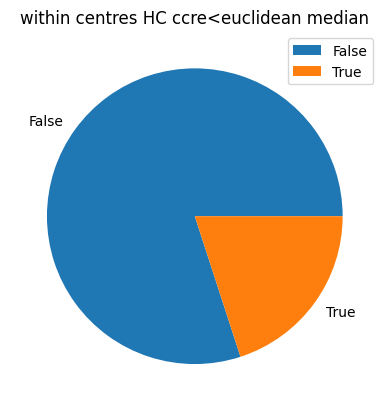

In [336]:
values = compare_within[compare_within['formula'].str[5:7] == 'HC']['ccre<euclidean'].astype(int)
plot_pie(values, 'within centres HC ccre<euclidean median')


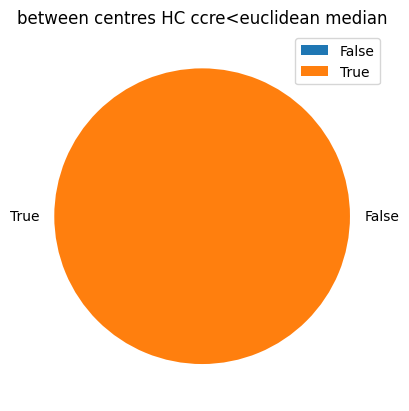

In [337]:
values = compare_outside[compare_outside['formula'].str[5:7] == 'HC']['ccre<euclidean'].astype(int)
plot_pie(values, 'between centres HC ccre<euclidean median')

<h1>HC != PD or AD</h1>

In [338]:
compare_euclidean_ccre_df[(compare_euclidean_ccre_df['formula'].str[5:7] == 'HC') &(compare_euclidean_ccre_df['second_diagnosis'].isin(['PD', 'AD']))]

,formula,hospital,first_diagnosis,second_diagnosis,ccre_average,euclidean distance average,ccre<euclidean
0,mean(HC)/ mean(between HC and PD),UMCG_UMCG,HC,PD,0.501061,0.752090,True
2,mean(HC)/ mean(between HC and AD),UMCG_UMCG,HC,AD,0.998156,0.608722,False
6,mean(HC)/ mean(between HC and PD),UMCG_UGOSM,HC,PD,0.698864,0.822434,True
8,mean(HC)/ mean(between HC and AD),UMCG_UGOSM,HC,AD,0.571922,0.642064,True
12,mean(HC)/ mean(between HC and PD),UMCG_CUN,HC,PD,0.769283,0.906771,True
14,mean(HC)/ mean(between HC and PD),UGOSM_UMCG,HC,PD,0.697106,0.822434,True
16,mean(HC)/ mean(between HC and AD),UGOSM_UMCG,HC,AD,0.571922,0.642064,True
20,mean(HC)/ mean(between HC and PD),UGOSM_UGOSM,HC,PD,1.117098,0.839832,False
22,mean(HC)/ mean(between HC and AD),UGOSM_UGOSM,HC,AD,0.862189,0.630641,False
26,mean(HC)/ mean(between HC and PD),UGOSM_CUN,HC,PD,0.719609,0.947423,True


<h1>AD or PD != AD or PD</h1>

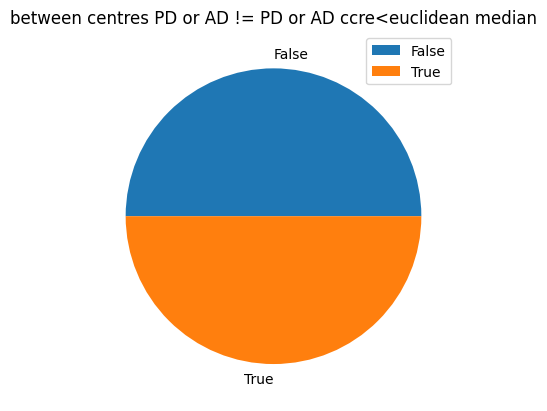

In [339]:
values = compare_within[compare_within['first_diagnosis'] == 'AD']['ccre<euclidean'].astype(int)
plot_pie(values, 'between centres PD or AD != PD or AD ccre<euclidean median')

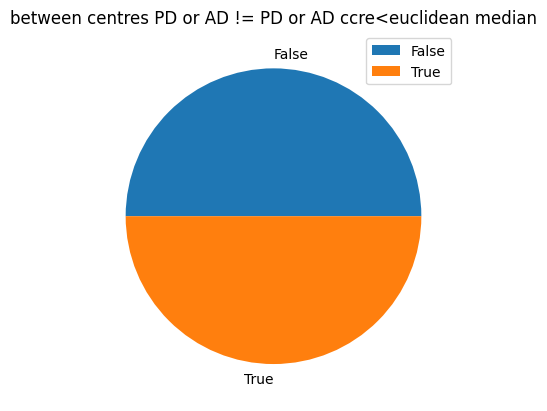

In [340]:
values = compare_outside[compare_outside['first_diagnosis'] == 'AD']['ccre<euclidean'].astype(int)
plot_pie(values, 'between centres PD or AD != PD or AD ccre<euclidean median')

<h1>PD > AD</h1>

In [341]:
compare_euclidean_ccre_df[compare_euclidean_ccre_df['formula'].str[5:7].isin(['PD', 'AD'])]

,formula,hospital,first_diagnosis,second_diagnosis,ccre_average,euclidean distance average,ccre<euclidean
1,mean(PD)/ mean(between HC and PD),UMCG_UMCG,HC,PD,6.460792,0.969881,False
3,mean(AD)/ mean(between HC and AD),UMCG_UMCG,HC,AD,25.493221,0.927589,False
4,mean(AD)/ mean(between AD and PD),UMCG_UMCG,AD,PD,1.676293,1.016331,False
5,mean(PD)/ mean(between AD and PD),UMCG_UMCG,AD,PD,0.846288,0.860096,True
7,mean(PD)/ mean(between HC and PD),UMCG_UGOSM,HC,PD,2.903729,1.039310,False
9,mean(AD)/ mean(between HC and AD),UMCG_UGOSM,HC,AD,7.556021,0.931350,False
10,mean(AD)/ mean(between AD and PD),UMCG_UGOSM,AD,PD,1.736460,1.024056,False
11,mean(PD)/ mean(between AD and PD),UMCG_UGOSM,AD,PD,0.546100,0.892141,True
13,mean(PD)/ mean(between HC and PD),UMCG_CUN,HC,PD,3.245792,1.009144,False
15,mean(PD)/ mean(between HC and PD),UGOSM_UMCG,HC,PD,2.920879,1.039310,False


<h1>kNN</h1>
Because we have all the distances we dont need to implement the actual model but instead can use the adjacency matrix

In [342]:
CCRE_matrix

list_of_labels = []
for i in list_of_id:
    hospital = sorted_df[sorted_df['id_x'] == i].iloc[0]['hospital'].split('_')[0]
    diagnosis = sorted_df[sorted_df['id_x'] == i].iloc[0]['diagnosis'].split('_')[0]
    list_of_labels.append(f'{hospital}_{diagnosis}')

In [343]:
import random
testlist = [
    [round((position[0] - 0) /100*20), position[0], 0],
    [round((position[1] - position[0]) /100*20),position[1], position[0]],
    [round((position[2] - position[1]) /100*20),position[2], position[1]],
    [round((position[3] - position[2]) /100*20),position[3], position[2]],
    [round((position[4] - position[3]) /100*20),position[4], position[3]],
    [round((position[5] - position[4]) /100*20),position[5], position[4]],
    [round((position[6] - position[5]) /100*20),position[6], position[5]],
    [round((position[7] - position[6]) /100*20),position[7], position[6]],
    ]
def randomints(amount, position1, position2):
    return random.sample(range(position1, position2), amount)
testset =[]
for i in testlist:
    for j in randomints(i[0], i[2], i[1]):
        testset.append(j)
testset

[9,
 11,
 10,
 19,
 20,
 22,
 32,
 36,
 38,
 33,
 86,
 67,
 90,
 52,
 53,
 89,
 85,
 60,
 109,
 115,
 106,
 120,
 112,
 107,
 114,
 127,
 129,
 170,
 168,
 177,
 161,
 143,
 169,
 174,
 162,
 180,
 182,
 189,
 183,
 195,
 191,
 206,
 215,
 214,
 202,
 227,
 229]

In [344]:
testset[::-1]

[229,
 227,
 202,
 214,
 215,
 206,
 191,
 195,
 183,
 189,
 182,
 180,
 162,
 174,
 169,
 143,
 161,
 177,
 168,
 170,
 129,
 127,
 114,
 107,
 112,
 120,
 106,
 115,
 109,
 60,
 85,
 89,
 53,
 52,
 90,
 67,
 86,
 33,
 38,
 36,
 32,
 22,
 20,
 19,
 10,
 11,
 9]

In [345]:
matrices = copy.deepcopy(CCRE_matrix)
for i in matrices:
    for j in testset[::-1]:

        i.pop(j)

def knn(k, x, y):
    correct_predicted = []
    for index,matrix in enumerate(matrices):
        if index in testset:
            
            actual_value = y[0]
            predicted_values = []
            for K in range(1, k):
                number = [i for i in range(len(CCRE_matrix[index])) if CCRE_matrix[index][i] == (sorted(matrix, reverse=True)[K])][0]
            
                predicted_values.append(list_of_labels[number].split('_')[1])
            counter = Counter(predicted_values)
            predicted_value = max(counter, key=counter.get)
            correct_predicted.append([list_of_labels[number] , actual_value, predicted_value == actual_value.split('_')[1]])
    
    return correct_predicted

for i in range(2,20):
    test = knn(i, copy.deepcopy(CCRE_matrix), list_of_labels)    
    true = 0
    false = 0
    for j in test:
        if j[2]:
            true +=1
        else:
            false +=1

    print(f'neighbours = {i-1}, incorrect predicted = {false}, correct predicted = {true}')

neighbours = 1, incorrect predicted = 32, correct predicted = 15
neighbours = 2, incorrect predicted = 32, correct predicted = 15
neighbours = 3, incorrect predicted = 36, correct predicted = 11
neighbours = 4, incorrect predicted = 36, correct predicted = 11
neighbours = 5, incorrect predicted = 37, correct predicted = 10
neighbours = 6, incorrect predicted = 38, correct predicted = 9
neighbours = 7, incorrect predicted = 37, correct predicted = 10
neighbours = 8, incorrect predicted = 36, correct predicted = 11
neighbours = 9, incorrect predicted = 37, correct predicted = 10
neighbours = 10, incorrect predicted = 35, correct predicted = 12
neighbours = 11, incorrect predicted = 37, correct predicted = 10
neighbours = 12, incorrect predicted = 37, correct predicted = 10
neighbours = 13, incorrect predicted = 37, correct predicted = 10
neighbours = 14, incorrect predicted = 39, correct predicted = 8
neighbours = 15, incorrect predicted = 39, correct predicted = 8
neighbours = 16, incor

In [346]:
matrices = copy.deepcopy(euclidean_matrix)
for i in matrices:
    for j in testset[::-1]:

        i.pop(j)

def knn(k, x, y):
    correct_predicted = []
    for index,matrix in enumerate(matrices):
        
        if index in testset:
            actual_value = y[0][-2:]
            if actual_value == 'AD' or actual_value =='PD':
                actual_value = 'ill'
            else:
                actual_value = 'notill'
            predicted_values = []
            
            for K in range(1, k):
            
                number = [i for i in range(len(euclidean_matrix[index])) if euclidean_matrix[index][i] == (sorted(matrix)[K])][0]
                label = list_of_labels[number].split('_')[1]
                if label == 'AD' or label == 'PD':
                
                    predicted_values.append('ill')
                else:
                    predicted_values.append('notill')
            counter = Counter(predicted_values)
            predicted_value = max(counter, key=counter.get)
           
            correct_predicted.append([list_of_labels[number] , actual_value, predicted_value == actual_value])
    
    return correct_predicted

for i in range(2,20):
    test = knn(i, copy.deepcopy(CCRE_matrix), list_of_labels)    
    true = 0
    false = 0
    for j in test:
        if j[2]:
            true +=1
        else:
            false +=1

    print(f'neighbours = {i-1}, incorrect predicted = {false}, correct predicted = {true}')

neighbours = 1, incorrect predicted = 32, correct predicted = 15
neighbours = 2, incorrect predicted = 32, correct predicted = 15
neighbours = 3, incorrect predicted = 33, correct predicted = 14
neighbours = 4, incorrect predicted = 32, correct predicted = 15
neighbours = 5, incorrect predicted = 32, correct predicted = 15
neighbours = 6, incorrect predicted = 32, correct predicted = 15
neighbours = 7, incorrect predicted = 32, correct predicted = 15
neighbours = 8, incorrect predicted = 32, correct predicted = 15
neighbours = 9, incorrect predicted = 34, correct predicted = 13
neighbours = 10, incorrect predicted = 34, correct predicted = 13
neighbours = 11, incorrect predicted = 35, correct predicted = 12
neighbours = 12, incorrect predicted = 33, correct predicted = 14
neighbours = 13, incorrect predicted = 33, correct predicted = 14
neighbours = 14, incorrect predicted = 33, correct predicted = 14
neighbours = 15, incorrect predicted = 33, correct predicted = 14
neighbours = 16, in

In [347]:
matrices = copy.deepcopy(CCRE_matrix)
for i in matrices:
    for j in testset[::-1]:

        i.pop(j)

def knn(k, x, y):
    correct_predicted = []
    for index,matrix in enumerate(matrices):
        
        if index in testset:
            actual_value = y[0][-2:]
            if actual_value == 'AD' or actual_value =='PD':
                actual_value = 'ill'
            else:
                actual_value = 'notill'
            predicted_values = []
            
            for K in range(1, k):
            
                number = [i for i in range(len(CCRE_matrix[index])) if CCRE_matrix[index][i] == (sorted(matrix)[K])][0]
                label = list_of_labels[number].split('_')[1]
                
                if label == 'AD' or label == 'PD':
                
                    predicted_values.append('ill')
                else:
                    predicted_values.append('notill')
            counter = Counter(predicted_values)
            predicted_value = max(counter, key=counter.get)
            correct_predicted.append([list_of_labels[number] , actual_value, predicted_value == actual_value])
    
    return correct_predicted

for i in range(2,20):
    test = knn(i, copy.deepcopy(CCRE_matrix), list_of_labels)    
    true = 0
    false = 0
    for j in test:
        if j[2]:
            true +=1
        else:
            false +=1

    print(f'neighbours = {i-1}, incorrect predicted = {false}, correct predicted = {true}')

neighbours = 1, incorrect predicted = 9, correct predicted = 38
neighbours = 2, incorrect predicted = 9, correct predicted = 38
neighbours = 3, incorrect predicted = 9, correct predicted = 38
neighbours = 4, incorrect predicted = 9, correct predicted = 38
neighbours = 5, incorrect predicted = 9, correct predicted = 38
neighbours = 6, incorrect predicted = 9, correct predicted = 38
neighbours = 7, incorrect predicted = 9, correct predicted = 38
neighbours = 8, incorrect predicted = 9, correct predicted = 38
neighbours = 9, incorrect predicted = 9, correct predicted = 38
neighbours = 10, incorrect predicted = 9, correct predicted = 38
neighbours = 11, incorrect predicted = 9, correct predicted = 38
neighbours = 12, incorrect predicted = 9, correct predicted = 38
neighbours = 13, incorrect predicted = 9, correct predicted = 38
neighbours = 14, incorrect predicted = 9, correct predicted = 38
neighbours = 15, incorrect predicted = 9, correct predicted = 38
neighbours = 16, incorrect predict